In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
idx = pd.IndexSlice

https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [3]:
filename_path = '_input/01_ecdc/COVID-19-geographic-disbtribution-worldwide-2020-03-11.xls'

In [4]:
# Goal is to compute cumulative sum and grow_rate

In [5]:
df = pd.read_excel(filename_path, index_col='DateRep', parse_dates=True)
df.rename_axis('Date', inplace=True)
df.head()

,CountryExp,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
Date,,,,,,
2020-03-11,Afghanistan,0,0,AF,NaN,Non-EU/EEA
2020-03-11,Afghanistan,3,0,AF,NaN,Non-EU/EEA
2020-03-08,Afghanistan,3,0,AF,NaN,Non-EU/EEA
2020-03-02,Afghanistan,0,0,AF,NaN,Non-EU/EEA
2020-03-01,Afghanistan,0,0,AF,NaN,Non-EU/EEA


In [6]:
df.tail()

,CountryExp,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
Date,,,,,,
2020-01-03,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-01-02,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-01-01,Vietnam,0,0,VN,NaN,Non-EU/EEA
2019-12-31,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-03-11,Azerbaijan,11,0,AZ,NaN,Non-EU/EEA


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4729 entries, 2020-03-11 to 2020-03-11
Data columns (total 6 columns):
CountryExp      4729 non-null object
NewConfCases    4729 non-null int64
NewDeaths       4729 non-null int64
GeoId           4729 non-null object
Gaul1Nuts1      471 non-null object
EU              4729 non-null object
dtypes: int64(2), object(4)
memory usage: 258.6+ KB


In [8]:
df.describe()

,NewConfCases,NewDeaths
count,4729.000000,4729.000000
mean,25.085219,0.907591
std,294.544835,9.028609
min,-9.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,15141.000000,254.000000


In [9]:
df[['NewConfCases']].sum()

NewConfCases    118628
dtype: int64

In [10]:
df['CountryExp'].value_counts()

China                               72
United Kingdom                      72
Denmark                             72
United States of America            72
Australia                           72
                                    ..
Togo                                 1
Bhutan                               1
Bangladesh                           1
Cyprus                               1
Democratic Republic of the Congo     1
Name: CountryExp, Length: 107, dtype: int64

In [11]:
country_df = df.groupby(['CountryExp', 'Date']).sum()
country_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31             0          0
            2020-01-01             0          0
            2020-01-02             0          0
            2020-01-03             0          0
            2020-01-04             0          0
...                              ...        ...
Vietnam     2020-03-07             1          0
            2020-03-08             4          0
            2020-03-09             9          0
            2020-03-10             1          0
            2020-03-11             4          0

[4727 rows x 2 columns]

In [12]:
def growth_ratio(a, b):
    '''
    return growth ratio, it check denominator is larger than zero
    param: Value Today, Value Yesterday
    return: growth ratio
    '''
    if b > 0:
        return a/b
    else:
        return np.nan

In [13]:
pd.concat([country_df, country_df.shift(1)], axis=1).to_csv('temp.csv')

In [14]:
# I shift by 1 in order to align today data with yesterday data
# I need to unstack the country index before shifting
shift1_df = country_df.unstack(level=0).shift(1).stack(level=1).swaplevel(axis=0).sort_index()

In [15]:
grow_rate_new = pd.concat([country_df, shift1_df], axis=1).apply(lambda X: growth_ratio(X[0],X[2]), axis=1)
grow_rate_death = pd.concat([country_df, shift1_df], axis=1).apply(lambda X: growth_ratio(X[1],X[3]), axis=1)

In [16]:
grow_rate_new.rename('NewConfCases', inplace=True)
grow_rate_death.rename('NewDeaths', inplace=True)

CountryExp   Date      
Afghanistan  2019-12-31   NaN
             2020-01-01   NaN
             2020-01-02   NaN
             2020-01-03   NaN
             2020-01-04   NaN
                           ..
Vietnam      2020-03-07   NaN
             2020-03-08   NaN
             2020-03-09   NaN
             2020-03-10   NaN
             2020-03-11   NaN
Name: NewDeaths, Length: 4861, dtype: float64

In [17]:
growth_rate_df = pd.concat([grow_rate_new, grow_rate_death], axis=1)
growth_rate_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31           NaN        NaN
            2020-01-01           NaN        NaN
            2020-01-02           NaN        NaN
            2020-01-03           NaN        NaN
            2020-01-04           NaN        NaN
...                              ...        ...
Vietnam     2020-03-07           NaN        NaN
            2020-03-08      4.000000        NaN
            2020-03-09      2.250000        NaN
            2020-03-10      0.111111        NaN
            2020-03-11      4.000000        NaN

[4861 rows x 2 columns]

In [19]:
growth_rate_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31           NaN        NaN
            2020-01-01           NaN        NaN
            2020-01-02           NaN        NaN
            2020-01-03           NaN        NaN
            2020-01-04           NaN        NaN
...                              ...        ...
Vietnam     2020-03-07           NaN        NaN
            2020-03-08      4.000000        NaN
            2020-03-09      2.250000        NaN
            2020-03-10      0.111111        NaN
            2020-03-11      4.000000        NaN

[4861 rows x 2 columns]

In [43]:
#in order to perform cumsum within the country I need to unstack first
cumsum_df = country_df.unstack(level=0).cumsum().stack(level=1).swaplevel(axis=0).sort_index()
cumsum_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31           0.0        0.0
            2020-01-01           0.0        0.0
            2020-01-02           0.0        0.0
            2020-01-03           0.0        0.0
            2020-01-04           0.0        0.0
...                              ...        ...
Vietnam     2020-03-07          17.0        0.0
            2020-03-08          21.0        0.0
            2020-03-09          30.0        0.0
            2020-03-10          31.0        0.0
            2020-03-11          35.0        0.0

[4727 rows x 2 columns]

In [44]:
df = pd.concat({'difference' : country_df,
                'cumsum' : cumsum_df,
                'growth_rate' : growth_rate_df},axis=1)

In [45]:
df

difference                 cumsum            \
                       NewConfCases NewDeaths NewConfCases NewDeaths   
CountryExp  Date                                                       
Afghanistan 2019-12-31          0.0       0.0          0.0       0.0   
            2020-01-01          0.0       0.0          0.0       0.0   
            2020-01-02          0.0       0.0          0.0       0.0   
            2020-01-03          0.0       0.0          0.0       0.0   
            2020-01-04          0.0       0.0          0.0       0.0   
...                             ...       ...          ...       ...   
Vietnam     2020-03-07          1.0       0.0         17.0       0.0   
            2020-03-08          4.0       0.0         21.0       0.0   
            2020-03-09          9.0       0.0         30.0       0.0   
            2020-03-10          1.0       0.0         31.0       0.0   
            2020-03-11          4.0       0.0         35.0       0.0   

                        growth_rate            
                       NewConfCases NewDeaths  
CountryExp  Date                               
Afghanistan 2019-12-31          NaN       NaN  
            2020-01-01          NaN       NaN  
            2020-01-02          NaN       NaN  
            2020-01-03          NaN       NaN  
            2020-01-04          NaN       NaN  
...                             ...       ...  
Vietnam     2020-03-07          NaN       NaN  
            2020-03-08     4.000000       NaN  
            2020-03-09     2.250000       NaN  
            2020-03-10     0.111111       NaN  
            2020-03-11     4.000000       NaN  

[4861 rows x 6 columns]

In [46]:
ch_df = df.loc['Switzerland', idx[:,'NewConfCases']]

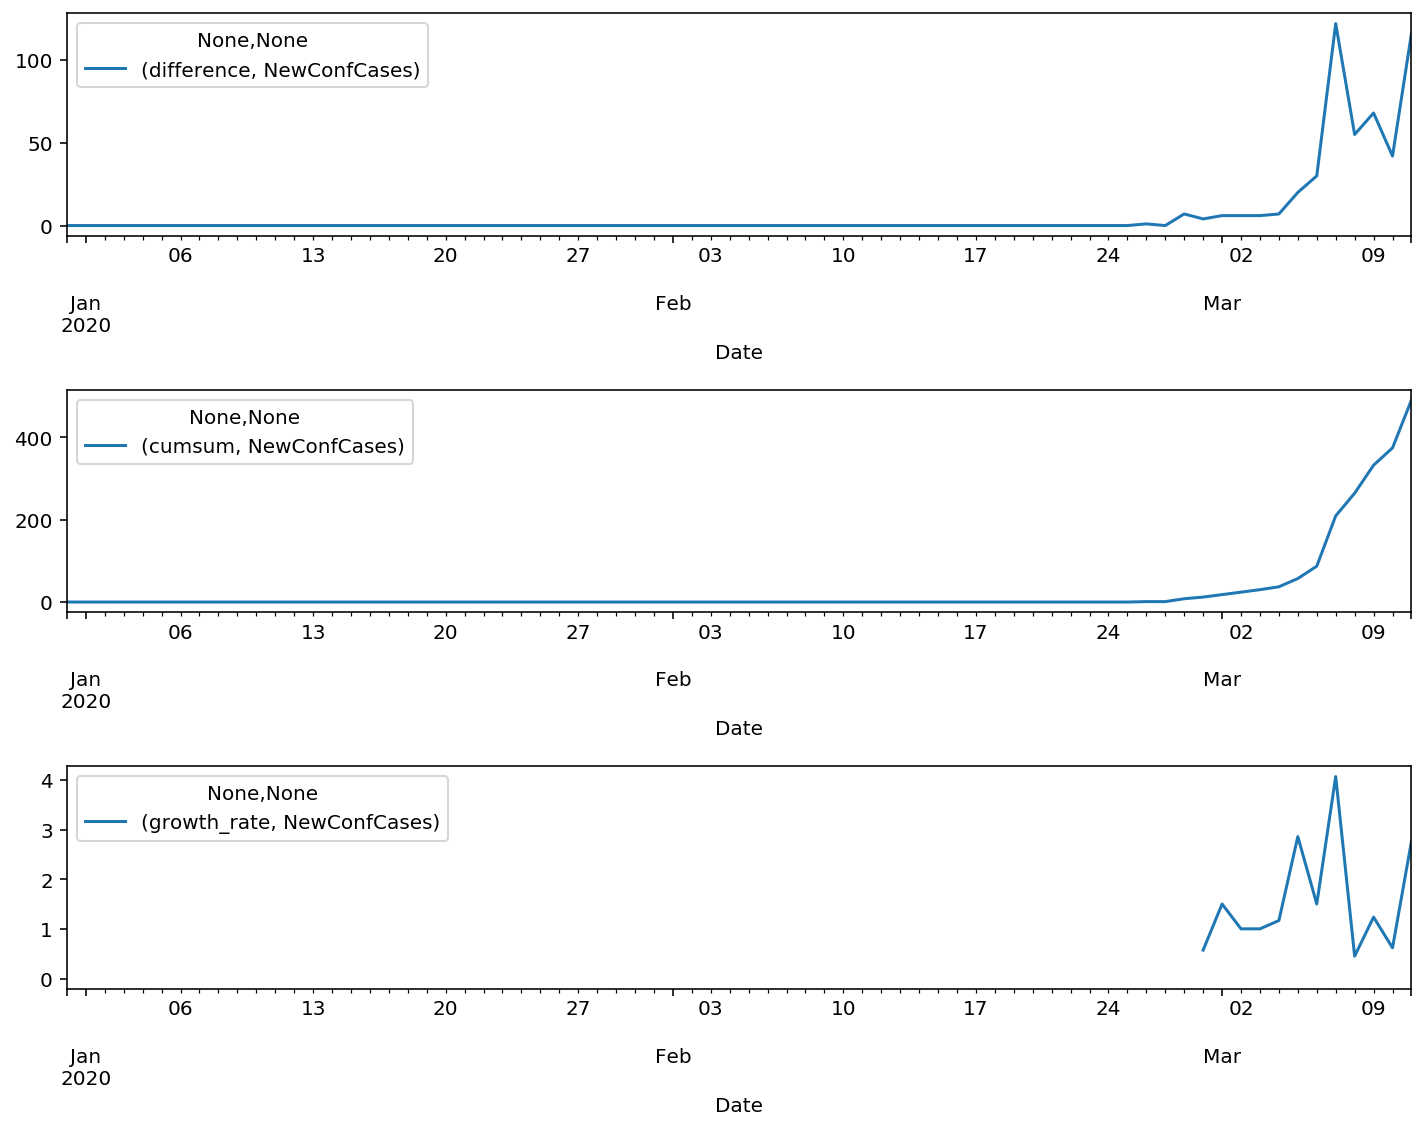

In [47]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
for ith, clm in enumerate(ch_df.columns):
    ch_df[[clm]].plot(ax=ax[ith])
    
plt.tight_layout()